<a href="https://colab.research.google.com/github/AOSPITIA/PruebaProteccion_AlejandroOspitia/blob/main/PruebaTecnica_AlejandroOspitia_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Prueba técnica - Punto 2**
**ESPECIALISTA DE CIENCIA DE DATOS**

**Alejandro Ospitia**

*Enunciado segundo punto*

La empresa recopila reseñas escritas por clientes sobre productos y servicios, y busca comprender el sentimiento expresado en estos textos
para apoyar decisiones estratégicas. Se proporciona un conjunto de reseñas de películas etiquetadas como positivas o negativas.
El objetivo es construir un modelo basado en redes neuronales que permita capturar patrones semánticos del lenguaje y predecir el sentimiento asociado a cada reseña.

In [1]:
#Importación de librerias
import pandas as pd
import re
from bs4 import BeautifulSoup

import spacy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None) #Esta línea se ejecuta para que se pueda ver todas las columnas de los dataframes en colab

In [3]:
#Carga de información y validación de caractéristicas iniciales
df = pd.read_table("/content/punto_2_3.csv")
print(df.shape)
# print(df.columns)
# df.sample(2) #se hace un muestreo aleatorio y revisar la estructura

(50000, 1)


#**Análisis del dataset**

A través del muestro del dataframe se observa que contiene una única columna la cual contiene reseñas de películas en texto y una variable binaria como último caracter. Para darle un tratamiento adecuado a la información se hará lo siguiente:

* Limpiar formatos incorrectos de HTML
* Limpiar caracteres no necesarios
* Estandarización de la información en minúsculas
* Generar un campo para la variable de clasificación (0: negativo, 1: positivo)

In [4]:
#Delimitación de la base
df["sentiment"] = df["review,sentiment"].astype(str).str[-1].astype(int)
df["review"] = df["review,sentiment"].astype(str).str[:-2]  # todo menos coma y dígito final
df = df[["review","sentiment"]]
df.sample(2)

,review,sentiment
4411,"That's a weird, weird movie and doesn't deserv...",0
38267,"Before I explain the ""Alias"" comment let me sa...",0


In [5]:
#Limpieza del campo de la reseña
#Se crea la función de limpieza para los caracteres relacionados a HTML, posterior dejar únicamente dejar letras y espacios en minúsculas
def limpieza(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = text.lower()
    return text

df["review"] = df["review"].apply(limpieza)

In [6]:
df.head(2)

,review,sentiment
0,in the teenager martha moxley maggie grace mo...,1
1,ok so i really like kris kristofferson and his...,0


#**Análisis descriptivo exploratorio**

Se realiza un análisis descriptivo para entender si los datos presentan un desbalance una vez obtenido el dataframe con el que se trabajara.

,proportion
sentiment,
1,0.5
0,0.5


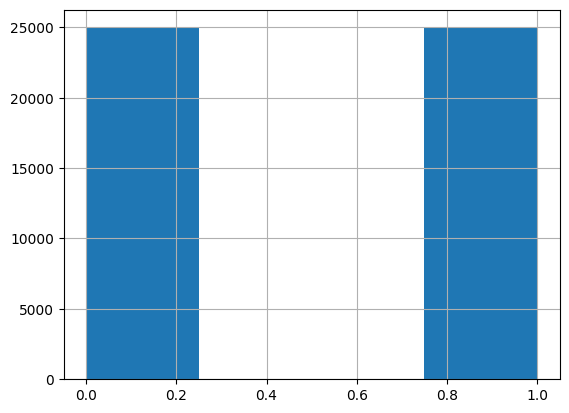

In [7]:
#Comportamiento de
df["sentiment"].hist(bins=4)
df["sentiment"].value_counts(normalize=True)
#Resultado: realizando la validación por la variable de clasificación se confirma que están en la misma proporción.

#**Aplicación técnicas de texto**

Teniendo que dataframe está balenciadoy ya se hicieron las correcciones necesarias, se procede a realizar las ténicas de tratamiento de texto

In [8]:
#Conformación de dataframes teniendo en cuenta la velocidad del procesamiento
#Procesamiento completo
df_original = df.copy()
#Procesamiento parcial
df_prueba = df.copy()
df_prueba = df_prueba.sample(5000)

In [9]:
#Selección de la proporción del df a procesar
df = df_prueba.copy()
# df = df_original.copy()

In [10]:
#Tokenización
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

#Función para lemmatizar y estandarizar el texto
# #__________Versión 1
def lemmatizacion(text):
    doc = nlp(text)
    tokens = []
    for token in doc:
        if token.is_alpha:
            tokens.append(token.lemma_)
    return " ".join(tokens)

df["review_lemmatizada"] = df["review"].apply(lemmatizacion)


#Se hace esta versión para procesar en lote y en paralelo, optimizando la aplicación
# #__________Versión 2
# def lemmatizacion_lote(texts):
#     docs = nlp.pipe(texts, n_process=4, batch_size=1000, disable=["ner","parser"])
#     return [" ".join([token.lemma_ for token in doc if token.is_alpha]) for doc in docs]

# df["review_lemmatizada"] = lemmatizacion_lote(df["review"])

In [11]:
df.sample(2)

,review,sentiment,review_lemmatizada
26900,having had a great grandfather be captured and...,1,have have a great grandfather be capture and s...
37671,slaughter high is intrinsically your emblemati...,0,slaughter high be intrinsically your emblemati...


#**Desarrollo del módelo**

Creación del modelo
* Creación de features para el modelo
* División de la base para entrenamiento (70), validación (10) y testeo (20)
* Creación vocabulario y tokenización
* Conversión texto a secuencias
* Aplicación LSTM
* Métricas y evaluación del modelo


In [12]:
#Definición de "X" y "y"

X = df["review_lemmatizada"]
y = df["sentiment"]

print("X shape:", X.shape),print("y shape:", y.shape)

X shape: (5000,)
y shape: (5000,)


(None, None)

In [13]:
# Generación 70% train, 30% temporal (10% Validación, 20% testeo)
X_train, X_temp, y_train, y_temp = train_test_split(X, y,test_size=0.3,random_state=42,stratify=y)

# Dividir 30% temp en 10% validación y 20% testeo
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp,test_size=2/3,random_state=42,stratify=y_temp)

print("Train:", len(X_train)/len(X))
print("Validation:", len(X_val)/len(X))
print("Test:", len(X_test)/len(X))

Train: 0.7
Validation: 0.1
Test: 0.2


In [14]:
#Creación vocabulario numérico
MAX_VOCAB = 15000 #Número de palabras a usar en el modelo.
tokenizer = Tokenizer(num_words=MAX_VOCAB,oov_token="<OOV>")

#Entrenamiento token
tokenizer.fit_on_texts(X_train)

#Entrenamiento token
word_index = tokenizer.word_index
print(f"Tamaño del vocabulario: {len(word_index)}") #Número de palabras únicas

Tamaño del vocabulario: 36528


In [15]:
#Generación modelo
VOCAB_SIZE = MAX_VOCAB
EMBEDDING_DIM = 128
MAX_SEQUENCE_LENGTH = 400

#usando LSTM
model = Sequential([Embedding(input_dim=VOCAB_SIZE,output_dim=EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH),
                  LSTM(128, return_sequences=False),
                  Dropout(0.5),
                  Dense(1, activation="sigmoid")])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [16]:
#Compilación del modelo
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [17]:
#Conversión texto a numérico y padding
#Versión 1
#Normalización
# X_train_seq = tokenizer.texts_to_sequences(X_train)
# X_val_seq   = tokenizer.texts_to_sequences(X_val)
# X_test_seq  = tokenizer.texts_to_sequences(X_test)
# X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
# X_val_pad   = pad_sequences(X_val_seq,   maxlen=MAX_SEQUENCE_LENGTH, padding="post")
# X_test_pad  = pad_sequences(X_test_seq,  maxlen=MAX_SEQUENCE_LENGTH, padding="post")

#Versión 2: en vez de tomar las 400 palabra se toman 300, 150 del inicio y 150 del final.
#Creación de la función
def head_tail(seq, maxlen=300):
    if len(seq) > maxlen:
        head = seq[:150]   # se toman las primeras 150 palabras
        tail = seq[-150:]  # se toman las últimas 150 palabras
        return head + tail
    return seq
#Normalización
MAX_SEQUENCE_LENGTH = 300
X_train_seq = [head_tail(s, maxlen=300) for s in tokenizer.texts_to_sequences(X_train)]
X_val_seq   = [head_tail(s, maxlen=300) for s in tokenizer.texts_to_sequences(X_val)]
X_test_seq  = [head_tail(s, maxlen=300) for s in tokenizer.texts_to_sequences(X_test)]
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
X_val_pad   = pad_sequences(X_val_seq,   maxlen=MAX_SEQUENCE_LENGTH, padding="post")
X_test_pad  = pad_sequences(X_test_seq,  maxlen=MAX_SEQUENCE_LENGTH, padding="post")


In [18]:
#Entrenamiento modelo
model.fit(X_train_pad, y_train,
          validation_data=(X_val_pad, y_val),
          epochs=10,
          batch_size=32)

Gráfica = model.fit(X_train_pad, y_train,
                    validation_data=(X_val_pad, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 65s 571ms/step - accuracy: 0.5072 - loss: 0.6941 - val_accuracy: 0.5160 - val_loss: 0.6926
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 78s 535ms/step - accuracy: 0.5203 - loss: 0.6878 - val_accuracy: 0.5300 - val_loss: 0.7069
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 60s 542ms/step - accuracy: 0.5520 - loss: 0.6800 - val_accuracy: 0.5360 - val_loss: 0.6844
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 58s 532ms/step - accuracy: 0.5917 - loss: 0.6211 - val_accuracy: 0.5180 - val_loss: 0.7232
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 83s 539ms/step - accuracy: 0.5995 - loss: 0.5740 - val_accuracy: 0.5120 - val_loss: 0.7587
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 59s 537ms/step - accuracy: 0.6110 - loss: 0.5537 - val_accuracy: 0.5020 - val_loss: 0.8235
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 59s 530ms/step - accuracy: 0.6163 - loss: 0.5419 - val_accuracy: 0.5020 - val_loss: 1.0175
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 83s 541ms/step - accuracy: 0.6230 - loss: 0

In [19]:
#Predicciones
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step


In [20]:
#Comparativa
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.5494    0.2545    0.3478       503
           1     0.5111    0.7887    0.6203       497

    accuracy                         0.5200      1000
   macro avg     0.5302    0.5216    0.4840      1000
weighted avg     0.5303    0.5200    0.4832      1000



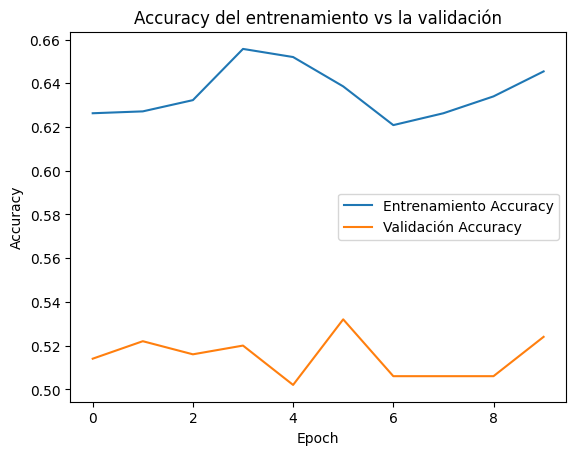

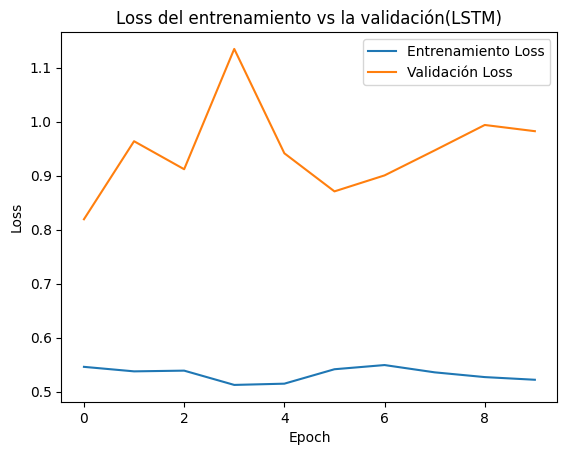

In [21]:
#Generación de gráficas de las métricas del modelo
#Accuracy (Precisión)
plt.figure()
plt.plot(Gráfica.history["accuracy"], label="Entrenamiento Accuracy")
plt.plot(Gráfica.history["val_accuracy"], label="Validación Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy del entrenamiento vs la validación")
plt.show()

#Loss (perdida)
plt.figure()
plt.plot(Gráfica.history["loss"], label="Entrenamiento Loss")
plt.plot(Gráfica.history["val_loss"], label="Validación Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss del entrenamiento vs la validación")
plt.show()

In [22]:
#Guardar el modelo
# model.save("sentiment_model.h5")
#Se deja la opción en caso de ser necesario guardar el modelo.

#**Conclusiones**

1. Hay que tener presente los consumos y específicaciones de las máquinas al momento de desarrollar y entrenar los modelos. En este caso se dejo la posibilidad de trabjar con una muestra de los datos o con todo el conjunto.
2. Se desarrolló e implementó la función "lemmatizacion" la cual aplica lemmatizado (mitigación del número de palabras a aprender).
3. Se implementó un número máximo de 15000 palabras en volabulario efectivo, permitiendo un amplio espectro para el modelo y se tokenizaron. Según la salida hay 36.704 palabras distintas.
3. Se aplicó una normalización a las reseñan donde se toman las 150 primeras y las 150 últimas palabras de cada reseña, ampliando el contexto de la calificación.
4. Se obtuvo un accuracy de 0.6870, que teniendo en cuenta que es modelo desarrollado desde cero y utilizado solo con el conjunto de muestra, es un resultado bueno.
5. Según la presición, el recall y el score f1 es un modelo equilibrado.
6. Breca moderada entre el conjunto de entrenamiento y validación respecto al acurracy.
7. Teniendo en cuenta la gráfica de Loss se ve una tendencia a la baja, indicando que el modelo está aprendiendo patrones reales y no ruido.
8. El modelo desarrollado es estable y posee características buenas en medición, sin embargo es limitado.